# Load pretrained model

In [2]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(ResNet18_Weights.DEFAULT)

for name, layer in model.named_children():
    print(name)
    print(layer)

conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu
ReLU(inplace=True)
maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

# Modify given pretrain model

1. modified given pretrain model
2. all model will be divided into "feature", "pool", and "fc"
3. take resnet-18 for example
4. if want to change another model, must modify this section

In [3]:
import torch.nn as nn

class Modifiedmodel(nn.Module):
    def __init__(self, model):
        super().__init__()
        feature = [*model.children()][:-2]
        avgpool = [*model.children()][-2]
        classifier = [*model.children()][-1]
        
        ################### architecture ###################
        self.feature = nn.Sequential(*feature)
        self.avgpool = avgpool
        self.classifier = classifier
        ####################################################
    
    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.classifier(x)
        
        return x

new_model = Modifiedmodel(model)

In [4]:
for name, layer in new_model.named_children():
    print(name)
    print(layer)


feature
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (con

# Grad-CAM

In [20]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model):
        self.probas = None        # save output probability
        self.output = None        # save output of forward propagation
        self.gradient = None      # save gradient
        self.feature_maps = None  # save feature map after cnn layer
        
        self.model = model
        self.features = model.feature     # stage of feature extraction
        self.avgpool = model.avgpool      # stage of average pooling
        self.flatten = nn.Flatten()
        self.classifier = model.classifier  # stage of classifier
    
    def _predict(self, img_tensor):
        """ produce predicted probability """ 
        with torch.no_grad():
            logits = self.model(img_tensor)   # output size = [batch, n_classes]
            probas = F.softmax(logits, dim=1) # output size = [batch, n_classes(prob)]
        
        self.probas = probas.detach().numpy().squeeze()  # [batch, n_classes] -> [n_classes, ]
    
    def _save_gradient(self, grad):
        """ hook function"""
        ##############################################
        # 1. escape gradient descent
        # 2. take [C, H, W] from first and only batch
        ###############################################
        self.gradient = grad.detach().numpy()[0]
    
    def _forward(self, img_tensor):
        """ forward propagation """
        
        feature_maps = self.features(img_tensor)
        avg_pool = self.avgpool(feature_maps)
        fc_input = self.flatten(avg_pool)
        logits = self.classifier(fc_input)
        
        #######################################################
        # 1. save final output
        # 2. register a hook function
        # 3. retain feature map of last convolutional layer
        #######################################################
        self.output = logits
        feature_maps.register_hook(self._save_gradient)
        self.feature_maps = feature_maps.detach().numpy().squeeze()
    
    def _backward(self, class_idx):
        """ backward propagation """
        onehot_target = torch.zeros(self.probas.shape, dtype=torch.float) # size: [n_classes]
        onehot_target = torch.unsqueeze(onehot_target, dim=0)             # size: [n_classes] -> [batch=1, n_classes]
        onehot_target[0][class_idx] = 1                                   # set value that we are intresting to 1
        
        self.model.zero_grad()
        self.output.backward(gradient=onehot_target)
    
    def _get_class_idx(self, i):
        class_idx = self.probas.argsort() # return index from small probability to high
        class_idx = class_idx[-i]
        
        return class_idx
    
    def generate_heatmap(self, img_tensor, class_idx):
        self.input_size = list(img_tensor.size())[2:] # size = [batch, C, H, W] -> [H, W]
        self._forward(img_tensor)
        self._backward(class_idx)
        
        ##################################################
        # 1. global average pooling, which output size = [C, ]
        # 2. since self.gradient is array, can't use torch.mean
        # 3. after reshape, output size = [C, 1, 1]
        ##################################################
        weights = np.mean(self.gradient, axis=(1, 2)) 
        weights = weights.reshape(-1, 1, 1)
        
        
        ##############################################################
        # 1. product weights and feature map, then sum (i.e. overlap)
        # 2. ReLU
        # 3. normalization
        # 4. resize to original size and interpolation
        ##############################################################
        heatmap = np.sum(weights * self.feature_maps, axis=0) 
        heatmap = np.maximum(heatmap, 0)                                                    # ReLU
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)  # normalization
        heatmap = heatmap * 255
        #heatmap = np.uint8(heatmap)
        heatmap = Image.fromarray(heatmap)
        heatmap = heatmap.resize(self.input_size, Image.ANTIALIAS)      # resize and interpolation
        heatmap = np.array(heatmap)
        
        return heatmap
    
    def plot_heatmap(self, original_img, img_tensor, top=1):
        self.input_size = list(img_tensor.size())[2:]
        self._predict(img_tensor)                      # obtain self.probas
        
        cols = top + 1
        plt.figure(figsize=(4 * cols, 4))
        
        for i in range(cols):
            if i == 0:
                plt.subplot(1, cols, i+1)
                plt.imshow(original_img) # plot original image
                plt.title("Original")
                plt.axis("off")
                
            else:
                class_idx = self._get_class_idx(i)                      # used to generate class to index
                heatmap = self.generate_heatmap(img_tensor, class_idx)  # included forward and back propagation
                
                plt.subplot(1, cols, i+1)
                plt.imshow(original_img, alpha=1.0)
                plt.imshow(heatmap, cmap="jet", alpha=0.7)
                plt.title("heatmap")
                plt.axis("off")


# Test
1. the first image load from ImageNet
2. the second image is my puppy, his name is 樂樂

## First image and test

In [18]:
from torchvision import transforms
from PIL import Image
import torch

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

img = Image.open("D:/Graduate Class/implement practice/PyTorch/Grad-CAM/cat.jpg")
img_tensor = transforms(img)
img_tensor = torch.unsqueeze(img_tensor, dim=0)
img_tensor.size()

torch.Size([1, 3, 224, 224])

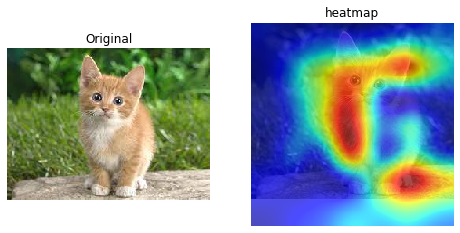

In [21]:
grad_cam = GradCAM(new_model)
grad_cam.plot_heatmap(img, img_tensor)

## Second image and test

In [22]:
img2 = Image.open("D:/Graduate Class/implement practice/PyTorch/Grad-CAM/S__11149324.jpg")
img2_tensor = transforms(img2)
img2_tensor = torch.unsqueeze(img2_tensor, dim=0)
img2_tensor.size()

torch.Size([1, 3, 224, 224])

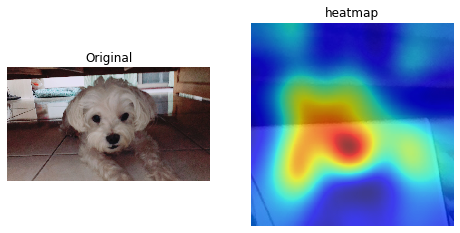

In [24]:
#grad_cam = GradCAM(new_model)
grad_cam.plot_heatmap(img2, img2_tensor)